<a href="https://colab.research.google.com/github/datarobot-community/mlops-examples/blob/master/Custom%20Model%20Examples/Cats%20and%20Dogs/Main_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras & DRUM on GPu

The point of this Notebook is to leverage GPUs for inference scoring for DNN models served up via [DRUM](www.github.com/datarobot/datarobot-user-models) all while monitoring said models via DataRobot MLOps Monitoring Agents 

## Setup

In order to walk through this notebook, we must set up the environment.  

This will entail
* installing `git-lfs`
* cloning `datarobot/datarobot-user-models` repo
* installing a bunch of python libraries
* for the prediction server, simplest route is to leverage flask.  If you choose to use uswgi + nginx, you will have to modify the uswgi ini file.
* turn on gpu (go to Edit -> Notebook Settings -> Hardware accelerator -> GPU)

### Install `git-lfs`

In [ ]:
!sudo apt install nginx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  geoip-database iproute2 libatm1 libgeoip1 libmnl0 libnginx-mod-http-geoip
  libnginx-mod-http-image-filter libnginx-mod-http-xslt-filter
  libnginx-mod-mail libnginx-mod-stream libxtables12 nginx-common nginx-core
Suggested packages:
  iproute2-doc geoip-bin fcgiwrap nginx-doc ssl-cert
The following NEW packages will be installed:
  geoip-database iproute2 libatm1 libgeoip1 libmnl0 libnginx-mod-http-geoip
  libnginx-mod-http-image-filter libnginx-mod-http-xslt-filter
  libnginx-mod-mail libnginx-mod-stream libxtables12 nginx nginx-common
  nginx-core
0 upgraded, 14 newly installed, 0 to remove and 21 not upgraded.
Need to get 3,544 kB of archives.
After this operation, 11.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libmnl0 amd64 1.0.4-2 [12.3 kB]
Get:2 http://archive.ubuntu.com/ubu

In [ ]:
!sudo apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 2s (889 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 144889 files and directories cur

### Clone DRUM

In [ ]:
!git lfs clone --single-branch --branch lior/monitoring https://github.com/datarobot/datarobot-user-models.git

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'datarobot-user-models'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 2088 (delta 136), reused 125 (delta 125), pack-reused 1813
Receiving objects: 100% (2088/2088), 9.27 MiB | 6.25 MiB/s, done.
Resolving deltas: 100% (1270/1270), done.
Git LFS: (27 of 27 files) 50.84 MB / 50.84 MB


### Install required packages to for DRUM to use Keras models

this will utilize `drum==1.2.0`

In [ ]:
!pip install /content/datarobot-user-models/dev_env/drum_mlops/drum-base/datarobot_drum-1.2.1rc5-py3-none-any.whl

Processing ./datarobot-user-models/dev_env/drum_mlops/drum-base/datarobot_drum-1.2.1rc5-py3-none-any.whl
     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 204kB 6.2MB/s 
     |████████████████████████████████| 153kB 11.0MB/s 
     |████████████████████████████████| 276kB 12.1MB/s 
     |████████████████████████████████| 788kB 14.6MB/s 
     |████████████████████████████████| 112kB 20.1MB/s 
     |████████████████████████████████| 204kB 17.8MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 808kB 17.1MB/s 
     |████████████████████████████████| 552kB 20.6MB/s 
  Created wheel for progress: filename=progress-1.5-cp36-none-any.whl size=8074 sha256=d64a89a35e6a962976630388fda32436660701251c1ce120b295a6ae5f13b65c
  Stored in directory: /root/.cache/pip/wheels/6c/c8/80/32a294e3041f006c661838c05a411c7b7ffc60ff939d14e116
  Created wheel for strictyaml: filename=strictyaml-1.0.6-cp36-none-any.whl size=

In [ ]:
!pip install -q -r /content/datarobot-user-models/public_dropin_environments/python3_keras/requirements.txt --no-cache-dir
!pip install requests_futures

     |████████████████████████████████| 516.2MB 1.3MB/s 
     |████████████████████████████████| 378kB 45.2MB/s 
     |████████████████████████████████| 14.6MB 3.0MB/s 
     |████████████████████████████████| 10.0MB 32.0MB/s 
     |████████████████████████████████| 6.9MB 39.3MB/s 
     |████████████████████████████████| 2.1MB 41.7MB/s 
     |████████████████████████████████| 3.0MB 32.9MB/s 
     |████████████████████████████████| 460kB 45.8MB/s 
     |████████████████████████████████| 51kB 43.9MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.0.3 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement pandas>=1.0.4, but you'll have pandas 1.0.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Created wheel for request

# __Restart runtime!!__

If you don't do this nothign will work

In [ ]:
!drum --version

drum 1.2.1rc5


In [ ]:
## load the model and review
import sys
sys.path.append('/content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib')
from model_utils import *
pipeline = deserialize_estimator_pipeline("/content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib")

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
pipeline.steps[-1][1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


# Test scoring with Keras model with DRUM
<a id="setup_complete"></a>

Next snippet is to test scoring.  Want to review the log and ensure that a gpu device is being attached to aid the dnn inference.  

With GPUs takes about 10 seconds, without takes much longer

In [ ]:
!drum score --code-dir /content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib \\
--input /content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv --verbose

Detected score mode
{'__custom_model_path__': '/content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib',
 'deployment_id': 'None',
 'input_filename': '/content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv',
 'model_id': 'None',
 'monitor': 'False',
 'monitor_settings': 'None',
 'negativeClassLabel': None,
 'output_filename': '/tmp/tmp9tgbw3vl',
 'positiveClassLabel': None,
 'run_language': 'python'}
Detected /content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib/custom.py .. trying to load hooks
Using TensorFlow backend.
2020-09-30 14:13:15.427782: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-09-30 14:13:15.431052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-30 14:13:15.431853: I tens

# Start the inference server locally

> Indented block



## If using uwsgi + nginx

Modify uwsgi config

When uswgi workers are instantiated, the ini file contains all the environment variables the workers will use when serving up the model.  To leverage GPU, you will need to update 

`/usr/local/lib/python3.6/dist-packages/mlpiper/components/restful/uwsgi_ini_template.py`

you should be able to click the link above to open file editor. 

The following cell will format all the environment variables so that you can copy the contents from the output of this cell and paste into the ini in the appropriate section.  Look for `# environment variables` around line 44

Also you will need to __delete__ `CUDA_VISIBLE_DEVICES` from the ini file

Mostly likely don't need all the environment variables listed below, but I'm too lazy to find out.  

In [ ]:
import os
## the output of this cell should be copy and pasted into the
## uwsgi ini file
## /usr/local/lib/python3.6/dist-packages/mlpiper/components/restful/uwsgi_ini_template.py
## additionaly delete CUDA_VISIBLE_DEVICES variable the ini file
for k,v in os.environ.items():
  if k not in ["DATALAB_SETTINGS_OVERRIDES", "PYTHONPATH"]:
    print("env = {}={}".format(k,v))

env = NO_GCE_CHECK=True
env = GCS_READ_CACHE_BLOCK_SIZE_MB=16
env = CLOUDSDK_CONFIG=/content/.config
env = __EGL_VENDOR_LIBRARY_DIRS=/usr/lib64-nvidia:/usr/share/glvnd/egl_vendor.d/
env = CUDA_VERSION=10.1.243
env = PATH=/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin
env = HOME=/root
env = LD_LIBRARY_PATH=/usr/lib64-nvidia
env = LANG=en_US.UTF-8
env = SHELL=/bin/bash
env = LIBRARY_PATH=/usr/local/cuda/lib64/stubs
env = CUDA_PKG_VERSION=10-1=10.1.243-1
env = SHLVL=1
env = GCE_METADATA_TIMEOUT=0
env = NCCL_VERSION=2.7.8
env = NVIDIA_VISIBLE_DEVICES=all
env = TF_FORCE_GPU_ALLOW_GROWTH=true
env = DEBIAN_FRONTEND=noninteractive
env = CUDNN_VERSION=7.6.5.32
env = LAST_FORCED_REBUILD=20200910
env = JPY_PARENT_PID=25
env = ENV=/root/.bashrc
env = GLIBCXX_FORCE_NEW=1
env = NVIDIA_DRIVER_CAPABILITIES=compute,utility
env = _=/tools/node/bin/node
env = LD_PRELOAD=/usr/lib/x86_64-linux-gnu/l

## Start the Server

There are a few keras examples available in the `DRUM` repo.  In what follows, you can eithe ruse the cat dog image classification example, or a keras models which was training on the boston housing prices dataset.

The example which follows is running on the cat dog classification model

In [ ]:
import subprocess
import requests
import pandas as pd
from io import BytesIO
import yaml
import time

In [ ]:
!sudo service nginx status

 * nginx is not running


## uSWGI + NGINX vs Flask

Starting the server, we'll use `subprocess.Popen`.  Take note below in the `run_server` variable.  If nyou want to use nginx, you should have updated the uwsgi ini file.  Also, you will provide the `--production` and `--max-workers` arguments.  If you don't care and didn't update uwsgi ini, make sure those arguments are commented out and you will leverage flask to serve up the model.  

In [ ]:
%%sh
mkdir -p /tmp/ta

In [ ]:
os.environ["MONITOR"] = "False"
os.environ["DEPLOYMENT_ID"] = "HOLD"
os.environ["MODEL_ID"] = "HOLD"
os.environ["MONITOR_SETTINGS"] = "spooler_type=filesystem;directory=/tmp/ta;max_files=5;file_max_size=1045876000"

In [ ]:
run_server = ["drum",
              "server",
              "--code-dir","/content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib", 
              "--address", "0.0.0.0:6789", 
              # "--production",   
              # "--max-workers", "10",
              "--show-perf",
              "--logging-level", "info",
              "--show-stacktrace",
              # "--monitor",
              "--verbose"
              ]
server = subprocess.Popen(run_server, stdout=subprocess.PIPE)

In [ ]:
!sudo service nginx status

 * nginx is not running


In [ ]:
# server.terminate()
# server.stdout.readlines()

[b'Detected REST server mode - this is an advanced option\n']

In [ ]:
# !nginx -s stop

## Ping the Server to make sure it is running

In [ ]:
## confirm the server is running
time.sleep(5) ## snoozing before pinging the server to give it time to actually start
print('check status')
requests.request("GET", "http://0.0.0.0:6789/").content

check status


b'{"message":"OK"}\n'

In [ ]:
# ## if you use flask this will return nginx is not running
# !sudo service nginx status

In [ ]:
df = pd.read_csv('/content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv')

In the cats and dogs dataset, the images have already been encoded.  If you can imagine having a pandas dataframe where each record is a file path, the following would be applied to encode the image.  
```
def convert_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode("utf-8")
    return encoded_string

df["image"] = df["path"].apply(lambda x: convert_to_base64(x))
```

In [ ]:
def score(data):
  b_buf = BytesIO()
  b_buf.write(data.to_csv(index=False).encode("utf-8"))
  b_buf.seek(0)
  
  url = "http://localhost:6789/predict/"
  files = [
    ('X', b_buf)
    # ('X', open('/content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv', 'rb'))
  ]
  response = requests.request("POST", url, files = files, timeout=None, verify=False)

  return response

## Send data to server for inference

In [ ]:
df[["image"]].head()

,image
0,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
1,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
2,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
3,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...
4,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAoHBwgHBgoICA...


In [ ]:
from PIL import Image
import io
import matplotlib.pyplot as plt
import base64
import numpy as np

# Take in base64 string and return a numpy image array
def stringToRGB(base64_string):
    imgdata = base64.b64decode(base64_string)
    image = Image.open(io.BytesIO(imgdata))
    return np.array(image)

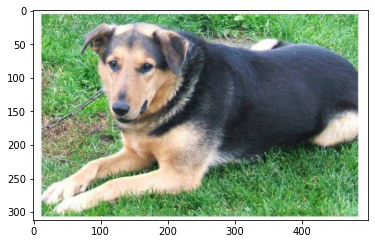

In [ ]:
plt.imshow(stringToRGB(df["image"].iloc[0]))

In [ ]:
%%timeit
# start_time = time.time()
score(df).json()["predictions"][0:5] ## score entire dataset but only show first 5 records
# end_time = time.time()
# print(end_time - start_time)

1 loop, best of 3: 1.88 s per loop


## If using NGINX

You can make concurrent requests to the prediction server

Obviously, `--max-workers` should be set.  

In [ ]:
# from requests_futures.sessions import FuturesSession
# from tqdm import notebook
# import math
# from io import StringIO

In [ ]:
# concurrency = 10
# sample_size = 20
# session = FuturesSession(max_workers=concurrency)

In [ ]:
# %%timeit
# # start_time = time.time()
# responses = []
# results = []
# results_df = pd.DataFrame()

# for i in notebook.tqdm(range(math.ceil(len(df)/sample_size))):
#     start_index = i * sample_size
#     end_index   = start_index + sample_size - 1
#     data = df.iloc[start_index:end_index]
#     b_buf = BytesIO()
#     b_buf.write(data.to_csv(index=False, header=True).encode("utf-8"))
#     b_buf.seek(0)  
#     url = "http://localhost:6789/predict/"
#     files = [
#       ('X', b_buf)
#       # ('X', open('/content/datarobot-user-models/tests/testdata/cats_dogs_small_training.csv', 'rb'))
#     ]
#     responses.append(session.post(url, files=files))
    
# for future in notebook.tqdm(responses):
#     resp = future.result().json()
#     results.append(resp)

# # end_time = time.time()
# # print(end_time - start_time)

In [ ]:
# server.terminate()
# server.stdout.readlines()

[b'Detected REST server mode - this is an advanced option\n',
 b"{'__custom_model_path__': '/content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib',\n",
 b" 'deployment_id': 'HOLD',\n",
 b" 'host': '0.0.0.0',\n",
 b" 'model_id': 'HOLD',\n",
 b" 'monitor': 'False',\n",
 b" 'monitor_settings': 'spooler_type=filesystem;directory=/tmp/ta;max_files=5;file_max_size=1045876000',\n",
 b" 'negativeClassLabel': None,\n",
 b" 'port': 6789,\n",
 b" 'positiveClassLabel': None,\n",
 b" 'run_language': 'python',\n",
 b" 'show_perf': True,\n",
 b" 'uwsgi_max_workers': None}\n",
 b'Detected /content/datarobot-user-models/model_templates/inference/python3_keras_vizai_joblib/custom.py .. trying to load hooks\n',
 b'\x1b \x1b\n',
 b'\x1b \x1b\n',
 b'\x1b============================================================\x1b\n',
 b'\x1bComponent: prediction_server\x1b\n',
 b'\x1bLanguage:  Python\x1b\n',
 b'\x1bOutput:\x1b\n',
 b'\x1b---------------------------------------------------

In [ ]:
!sudo service nginx status

 * nginx is not running


## Shutdown inference server

In [ ]:
## this endpoint is only available for non production server
url = "http://0.0.0.0:6789/shutdown/"

response = requests.request("POST", url)

print(response.text.encode('utf8'))

b'Server shutting down...'


In [ ]:
## run this if you using nginx
# !nginx -s stop

nginx: [error] open() "/run/nginx.pid" failed (2: No such file or directory)
